# Аналитическое исследование для компании «Мегалайн»

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Со стороны компании предоставлены данные 500 пользователей: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.

***Требуется:***
- произвести предварительный анализ тарифов на небольшой выборке клиентов;
- помесячно рассчитать количество произведенных звонков, отправленных смс-сообщений и истраченного интернет трафика;
- рассчитать помесячную выручку с каждого пользователя;
- описать поведение клиентов оператора, исходя из выборки;
- проверить утверждение: "средняя выручка пользователей тарифов «Ультра» и «Смарт» различается";
- проверить утверждение: "средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов".

По итогам исследования необходимо показать, какой из тарифов показывает себя наилучшим образом.

---
**Тариф «Смарт»**
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

*Стоимость услуг сверх тарифного пакета:*
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей
---

---
**Тариф «Ультра»**
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

*Стоимость услуг сверх тарифного пакета:*
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей
---

*«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.*

## Описание данных

**Таблица "users.csv" (информация о пользователях):**

- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

**Таблица "calls.csv" (информация о звонках):**
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

**Таблица "messages.csv" (информация о сообщениях):**
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

**Таблица "internet.csv" (информация об интернет-сессиях):**
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

**Таблица "tariffs.csv" (информация о тарифах):**
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Изучим общую информацию и подготовим данные

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

In [2]:
calls = pd.read_csv('datasets/calls.csv', index_col=0)
internet = pd.read_csv('datasets/internet.csv', index_col=0)
messages = pd.read_csv('datasets/messages.csv', index_col=0)
tariffs = pd.read_csv('datasets/tariffs.csv', index_col=0)
users = pd.read_csv('datasets/users.csv', index_col=0)

##### 1. Датафрейм 'calls'

In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 7.7+ MB


In [4]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


В первых двух строчках длительность звонка 0 минут. Изучим сколько таких звонков.

Зададим функцию которая будет сообщать количество нулевых звонков и долю к общему датафрейму.

In [5]:
def find_zero(df, column):
    zero = len(df[df[column] == 0])
    full = len(df)
    print(f'Количество нулевых значений - {zero}, что составляет примерно {int(zero/full*100)}% от общего количества.')

In [6]:
find_zero(calls,'duration')

Количество нулевых значений - 39613, что составляет примерно 19% от общего количества.


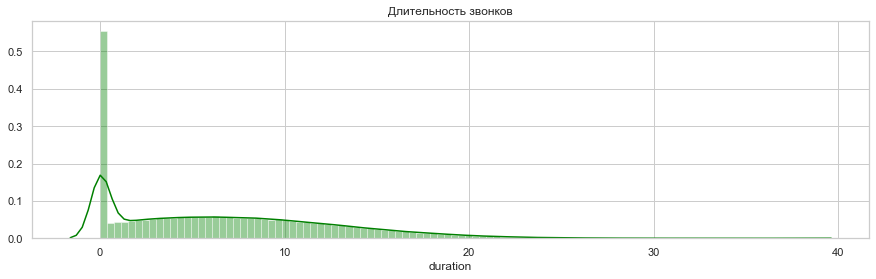

In [7]:
plt.figure(figsize=(15,4))
plt.title('Длительность звонков')
sns.distplot(calls['duration'], bins=100, color='green')

На гистограме нулевые звонки выглядят как выбросы.

Предположим что нулевые звонки - это просто звонки которые не состоялись (то есть звонящий не дозвонился до абонента, хотя факт набора номера был). Поскольку нас интересует количество потраченых минут, то удалим эти данные из датафрейма.

In [8]:
calls = calls[calls['duration'] != 0]

Округлим значаения звонков до минуты вверх:

In [9]:
calls['duration'] = calls['duration'].apply(np.ceil).astype('int')

In [10]:
calls.head()

,id,call_date,duration,user_id
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000
7,1000_7,2018-08-22,19,1000
8,1000_8,2018-09-15,19,1000


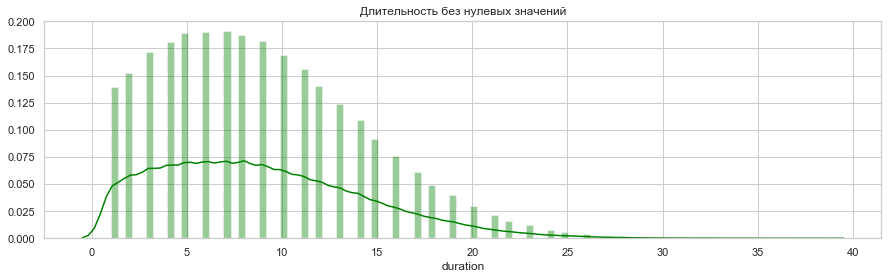

In [11]:
plt.figure(figsize=(15,4))
plt.title('Длительность без нулевых значений')
sns.distplot(calls['duration'], bins=100, color='green')

+ *Теперь показания по звонкам больше похожи на пуассоновское распределение.*

Преобразуем стоблец call_date в формат datetime:

In [12]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')

In [13]:
calls.dtypes

id                   object
call_date    datetime64[ns]
duration              int64
user_id               int64
dtype: object

##### 2. Датафрейм 'internet'

In [14]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [15]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Рассмотрим столбец mb_used на предмет аномалий:

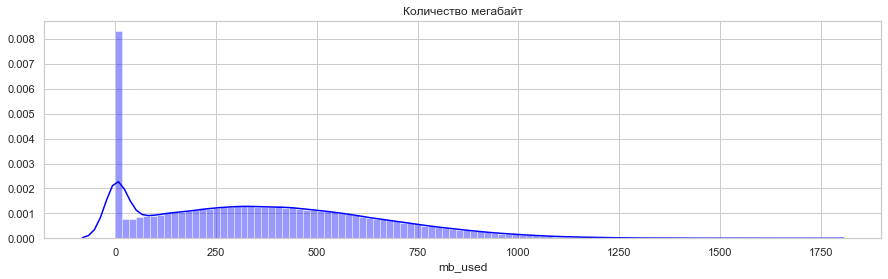

In [16]:
plt.figure(figsize=(15,4))
plt.title('Количество мегабайт')
sns.distplot(internet['mb_used'], bins=100, color='blue')

In [17]:
find_zero(internet, 'mb_used')

Количество нулевых значений - 19598, что составляет примерно 13% от общего количества.


Предполагаю что в данном датафрейме нулевые значения - это попытки воспользоваться интернетом. То есть сессия состоялась, но пакет доступных мегабайтов исчерпался. Откинем нулевые значения, так как нас интересует количество израсходованных мегабайтов.

In [18]:
internet = internet.query('mb_used != 0')

Округлим значения до верхнего целого числа:

In [19]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil).astype('int')

In [20]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,113,2018-11-25,1000
1,1000_1,1053,2018-09-07,1000
2,1000_2,1198,2018-06-25,1000
3,1000_3,551,2018-08-22,1000
4,1000_4,303,2018-09-24,1000


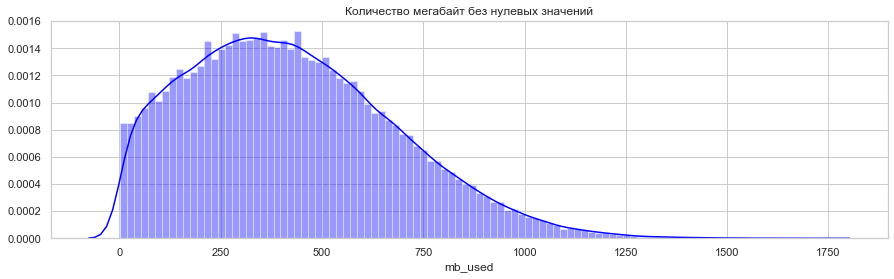

In [21]:
plt.figure(figsize=(15,4))
plt.title('Количество мегабайт без нулевых значений')
sns.distplot(internet['mb_used'], bins=100, color='blue')

+ *Данное распределение теперь также больше похоже на пуассоновское.*

Поправим формат в стоблце session_date:

In [22]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')

In [23]:
internet.dtypes

id                      object
mb_used                  int64
session_date    datetime64[ns]
user_id                  int64
dtype: object

##### 3. Датафрейм 'messages'

In [24]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.8+ MB


In [25]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


В данном датафрейме отмечен только факт отправки сообщения без дополнительной информации, поэтому только преобразим столбец даты в правильный:

In [26]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

In [27]:
messages.dtypes

id                      object
message_date    datetime64[ns]
user_id                  int64
dtype: object

##### 4. Датафрейм 'tariffs'

In [28]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mg_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 144.0+ bytes


In [29]:
tariffs

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


В этом датафрейме содержатся данные об исследуемых тарифах и никаких преобразований не требуют.

##### 5. Датафрейм 'users'

In [30]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 35.2+ KB


In [31]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Изучим, нет ли странностей в столбце age:

In [32]:
us_min = users['age'].min()
us_max = users['age'].max()
us_diff = us_max - us_min

(17, 76)

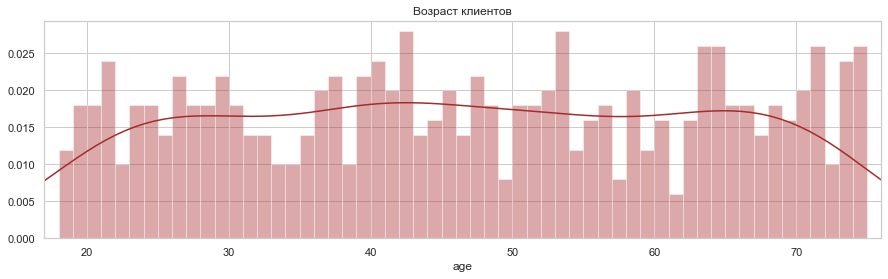

In [33]:
plt.figure(figsize=(15,4))
plt.title('Возраст клиентов')
sns.distplot(users['age'], bins=us_diff, color='brown')
plt.xlim(us_min-1, us_max+1)

+ *Аномалий в столбце не наблюдается*

Столбец churn_date преобразований не требует, так как это нормально, что человек продолжает использовать тариф. Но преобразуем заполненные записи в формат datetime:

In [34]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

Такое же преобразование произведем со столбцом reg_date:

In [35]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [36]:
users.dtypes

user_id                int64
age                    int64
churn_date    datetime64[ns]
city                  object
first_name            object
last_name             object
reg_date      datetime64[ns]
tariff                object
dtype: object

### Произведем рассчеты

##### 1. Посчитаем количество сделанных звонков и израсходованных минут разговора по месяцам:

In [37]:
calls['month'] = calls['call_date'].dt.month
calls.head()

,id,call_date,duration,user_id,month
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
7,1000_7,2018-08-22,19,1000,8
8,1000_8,2018-09-15,19,1000,9


In [38]:
calls_count_sum = calls.pivot_table(index=['user_id','month'], values='duration', aggfunc=['count', 'sum']).reset_index().set_index('user_id')
calls_count_sum.columns = ['month', 'calls_count', 'calls_sum']

Округлим до следующей минуты полученную сумму минут:

In [39]:
calls_count_sum['calls_sum'] = calls_count_sum['calls_sum'].apply(np.ceil).astype('int')
calls_count_sum.head()

,month,calls_count,calls_sum
user_id,,,
1000,5,17,159
1000,6,28,172
1000,7,41,340
1000,8,42,408
1000,9,46,466


##### 2. Посчитаем количество отправленных сообщений по месяцам:

In [40]:
messages['month'] = messages['message_date'].dt.month
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [41]:
messages_sent = messages.pivot_table(index=['user_id','month'], values='id', aggfunc='count').reset_index().set_index('user_id')
messages_sent.columns = ['month','messages_sent']
messages_sent.head()

,month,messages_sent
user_id,,
1000,5,22
1000,6,60
1000,7,75
1000,8,81
1000,9,57


##### 3. Посчитаем объем израсходованного интернет-трафика по месяцам:

In [42]:
internet['month'] = internet['session_date'].dt.month
internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,113,2018-11-25,1000,11
1,1000_1,1053,2018-09-07,1000,9
2,1000_2,1198,2018-06-25,1000,6
3,1000_3,551,2018-08-22,1000,8
4,1000_4,303,2018-09-24,1000,9


In [43]:
internet_spent = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum').reset_index().set_index('user_id')
internet_spent.columns = ['month','internet_spent']
internet_spent.head()

,month,internet_spent
user_id,,
1000,5,2256
1000,6,23257
1000,7,14016
1000,8,14070
1000,9,14581


Округлим количество потраченного интернета до целых верхней границы:

In [44]:
internet_spent['internet_spent'] = internet_spent['internet_spent'].apply(np.ceil).astype('int')
internet_spent.head()

,month,internet_spent
user_id,,
1000,5,2256
1000,6,23257
1000,7,14016
1000,8,14070
1000,9,14581


##### 4. Сведем полученные данные в единую таблицу:

- *Сформируем таблицу пользователей, местность и используемый тариф (остальные данные в рамках данного исследования нас не интересуют, однако в любой момент могут быть добавлены на данном этапе в таблицу):*

In [45]:
users_data = users.loc[:, ['user_id', 'city', 'tariff']]
users_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  500 non-null    int64 
 1   city     500 non-null    object
 2   tariff   500 non-null    object
dtypes: int64(1), object(2)
memory usage: 15.6+ KB


- *Создадим таблицу по звонкам:*

In [46]:
calls_data = users_data.merge(calls_count_sum, on='user_id', how='right')
calls_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3168 entries, 0 to 3167
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      3168 non-null   int64 
 1   city         3168 non-null   object
 2   tariff       3168 non-null   object
 3   month        3168 non-null   int64 
 4   calls_count  3168 non-null   int64 
 5   calls_sum    3168 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 173.2+ KB


- *Создадим таблицу по сообщениям:*

In [47]:
messages_data = users_data.merge(messages_sent, on='user_id', how='right')
messages_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2717 entries, 0 to 2716
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user_id        2717 non-null   int64 
 1   city           2717 non-null   object
 2   tariff         2717 non-null   object
 3   month          2717 non-null   int64 
 4   messages_sent  2717 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 127.4+ KB


- *Создадим таблицу по интернет-трафику:*

In [48]:
internet_data = users_data.merge(internet_spent, on='user_id', how='right')
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3201 entries, 0 to 3200
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         3201 non-null   int64 
 1   city            3201 non-null   object
 2   tariff          3201 non-null   object
 3   month           3201 non-null   int64 
 4   internet_spent  3201 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 150.0+ KB


- *Сформируем сводную таблицу по пользователям и месяцам (how='inner' по-умолчанию, потому что нам не интересны неполноценные траты):*

1. Прибавим сообщения:

In [49]:
total_data = calls_data.merge(messages_data)
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2673 entries, 0 to 2672
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user_id        2673 non-null   int64 
 1   city           2673 non-null   object
 2   tariff         2673 non-null   object
 3   month          2673 non-null   int64 
 4   calls_count    2673 non-null   int64 
 5   calls_sum      2673 non-null   int64 
 6   messages_sent  2673 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 167.1+ KB


2. Данные по интернет-траффику:

In [50]:
total_data = total_data.merge(internet_spent, on=['user_id','month'])
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2660 entries, 0 to 2659
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         2660 non-null   int64 
 1   city            2660 non-null   object
 2   tariff          2660 non-null   object
 3   month           2660 non-null   int64 
 4   calls_count     2660 non-null   int64 
 5   calls_sum       2660 non-null   int64 
 6   messages_sent   2660 non-null   int64 
 7   internet_spent  2660 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 187.0+ KB


- Приклеим параметры тарифов для каждого абонента:

In [51]:
total_data.columns

Index(['user_id', 'city', 'tariff', 'month', 'calls_count', 'calls_sum',
       'messages_sent', 'internet_spent'],
      dtype='object')

In [52]:
total_data.columns = ['user_id', 'city', 'tariff_name', 'month', 'calls_count', 'calls_sum',
       'messages_sent', 'internet_spent']

Изменили название столбца tariff на tariff_name для корректной склейки таблиц.

In [53]:
total_data.head()

,user_id,city,tariff_name,month,calls_count,calls_sum,messages_sent,internet_spent
0,1000,Краснодар,ultra,5,17,159,22,2256
1,1000,Краснодар,ultra,6,28,172,60,23257
2,1000,Краснодар,ultra,7,41,340,75,14016
3,1000,Краснодар,ultra,8,42,408,81,14070
4,1000,Краснодар,ultra,9,46,466,57,14581


In [54]:
total_data = total_data.merge(tariffs, on='tariff_name')

In [55]:
total_data.head()

,user_id,city,tariff_name,month,calls_count,calls_sum,messages_sent,internet_spent,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,Краснодар,ultra,5,17,159,22,2256,1000,30720,3000,1950,150,1,1
1,1000,Краснодар,ultra,6,28,172,60,23257,1000,30720,3000,1950,150,1,1
2,1000,Краснодар,ultra,7,41,340,75,14016,1000,30720,3000,1950,150,1,1
3,1000,Краснодар,ultra,8,42,408,81,14070,1000,30720,3000,1950,150,1,1
4,1000,Краснодар,ultra,9,46,466,57,14581,1000,30720,3000,1950,150,1,1


- *Рассчитаем помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану):*

*Здесь необходимо ввести дополнительные условия, поскольку иначе простой вычет из фактически потраченных единиц величины включенных единиц даст отрицательные значения и компания может оказаться еще и "должна" своему абоненту. Поэтому мы будем вычислять разницу только в тех случаях, где количество потраченных единиц превысило бесплатный порог.*

In [56]:
def revenue (row):
    inc_mins = row['minutes_included']
    inc_msgs = row['messages_included']
    inc_mgbs = row['mg_per_month_included']
    mins = row['calls_sum']
    msgs = row['messages_sent']
    mgbs = row['internet_spent']
    fee = row['rub_monthly_fee']
    rub_per_min = row['rub_per_minute']
    rub_per_mes = row['rub_per_message']
    rub_per_gb = row['rub_per_gb']
    
    over_mins = 0
    over_msgs = 0
    over_gbs = 0
    
    if mins > inc_mins:
        over_mins = mins - inc_mins
    if msgs > inc_msgs:
        over_msgs = msgs - inc_msgs
    if mgbs > inc_mgbs:
        over_gbs = (mgbs - inc_mgbs) / 1024
    
    return fee + over_mins * rub_per_min + over_msgs * rub_per_mes + over_gbs * rub_per_gb

*Внесена поправка, так как рассчет трафика указан в мегабайтах, а стоимость сверх тарифа указана в гигабайтах (1 ГБ = 1024 МБ).*

In [57]:
total_data['revenue'] = total_data.apply(revenue, axis=1).round(2)

*Полученные значения округлили до копеек.*

Проверим как сработала функция:

In [58]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2660 entries, 0 to 2659
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                2660 non-null   int64  
 1   city                   2660 non-null   object 
 2   tariff_name            2660 non-null   object 
 3   month                  2660 non-null   int64  
 4   calls_count            2660 non-null   int64  
 5   calls_sum              2660 non-null   int64  
 6   messages_sent          2660 non-null   int64  
 7   internet_spent         2660 non-null   int64  
 8   messages_included      2660 non-null   int64  
 9   mg_per_month_included  2660 non-null   int64  
 10  minutes_included       2660 non-null   int64  
 11  rub_monthly_fee        2660 non-null   int64  
 12  rub_per_gb             2660 non-null   int64  
 13  rub_per_message        2660 non-null   int64  
 14  rub_per_minute         2660 non-null   int64  
 15  reve

In [59]:
total_data.columns

Index(['user_id', 'city', 'tariff_name', 'month', 'calls_count', 'calls_sum',
       'messages_sent', 'internet_spent', 'messages_included',
       'mg_per_month_included', 'minutes_included', 'rub_monthly_fee',
       'rub_per_gb', 'rub_per_message', 'rub_per_minute', 'revenue'],
      dtype='object')

In [60]:
total_data = total_data.loc[:, ['user_id', 'city', 'tariff_name', 'month', 'calls_count', 'calls_sum',
       'messages_sent', 'internet_spent', 'revenue']]

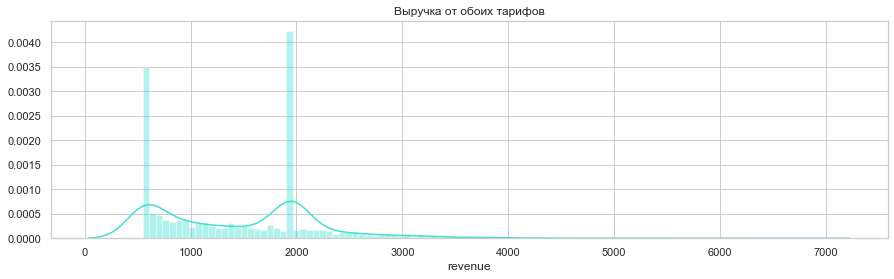

In [61]:
plt.figure(figsize=(15,4))
plt.title('Выручка от обоих тарифов')
sns.distplot(total_data['revenue'], bins=100, color='turquoise')

In [62]:
total_data['revenue'].describe()

count    2660.000000
mean     1461.642094
std       781.641162
min       550.000000
25%       677.992500
50%      1484.700000
75%      1950.000000
max      6711.020000
Name: revenue, dtype: float64

In [63]:
total_data.head()

,user_id,city,tariff_name,month,calls_count,calls_sum,messages_sent,internet_spent,revenue
0,1000,Краснодар,ultra,5,17,159,22,2256,1950.0
1,1000,Краснодар,ultra,6,28,172,60,23257,1950.0
2,1000,Краснодар,ultra,7,41,340,75,14016,1950.0
3,1000,Краснодар,ultra,8,42,408,81,14070,1950.0
4,1000,Краснодар,ultra,9,46,466,57,14581,1950.0


Гистограма и описание показывают нормальные, "здоровые" показатели. Минимальная оплата случилась по тарифу "Smart" в 550 руб. В 3м квартиле оказалась абонентская плата по тарифу "Ultra".

### Проанализируем данные

***Задача***: опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

Преобразуем количество потраченного интернета из мегабайтов в гигабайты для удобства рассчетов и сохраним в отдельный столбец:

In [64]:
total_data['internet_spent_gb'] = (total_data['internet_spent']/1024).round(3)
total_data.head()

,user_id,city,tariff_name,month,calls_count,calls_sum,messages_sent,internet_spent,revenue,internet_spent_gb
0,1000,Краснодар,ultra,5,17,159,22,2256,1950.0,2.203
1,1000,Краснодар,ultra,6,28,172,60,23257,1950.0,22.712
2,1000,Краснодар,ultra,7,41,340,75,14016,1950.0,13.688
3,1000,Краснодар,ultra,8,42,408,81,14070,1950.0,13.740
4,1000,Краснодар,ultra,9,46,466,57,14581,1950.0,14.239


In [65]:
data_pivot = total_data.pivot_table(index=['month','tariff_name'], values=['revenue','calls_sum', 'messages_sent', 'internet_spent_gb'], aggfunc=['mean', 'var', 'std']).reset_index()

In [66]:
data_pivot.columns=['month',
            'tariff_name',
            'mean_mins',
            'mean_gbs',
            'mean_msgs',
            'mean_revenue',
            'var_mins',
            'var_gbs',
            'var_msgs',
            'var_revenue',
            'std_mins',
            'std_gbs',
            'std_msgs',
            'std_revenue']

In [67]:
data_pivot.head()

,month,tariff_name,mean_mins,mean_gbs,mean_msgs,mean_revenue,var_mins,var_gbs,var_msgs,var_revenue,std_mins,std_gbs,std_msgs,std_revenue
0,1,smart,217.700000,8.477667,19.733333,719.680667,23363.389655,40.721536,258.547126,197735.059227,152.850874,6.381343,16.079401,444.674105
1,1,ultra,476.000000,13.674571,43.428571,1950.000000,70909.000000,27.601456,765.285714,0.000000,266.287439,5.253709,27.663798,0.000000
2,2,smart,311.740000,11.674300,27.940000,800.570800,38097.665714,33.926420,440.465714,265943.491726,195.186233,5.824639,20.987275,515.697093
3,2,ultra,400.000000,14.557214,37.285714,1989.509286,109635.230769,122.569575,660.219780,10093.648746,331.112112,11.071114,25.694742,100.467153
4,3,smart,393.086957,14.315884,35.550725,1079.880725,38040.933504,32.416409,669.780477,435858.030422,195.040851,5.693541,25.880117,660.195449


Соберем функцию, которая позволит сравнивать тарифы по разным параметрам:

In [68]:
def make_a_plot(data, row, palette='Set1'):
    tariff_name = data['tariff_name'].array
    month = data['month'].array
    month_list = ['январь', 'февраль', 'март', 'апрель', 'май','июнь', 'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь']
    month_total_list = []
    for mon in month:
        month_total_list.append(month_list[mon-1])
    vals = data[row]
    plot = pd.DataFrame({'month': month_total_list, 'tariff': tariff_name, 'vals': vals})
    plt.figure(figsize=(15,6))
    sns.barplot(x='month', y='vals', hue='tariff',data=plot, palette=palette)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(row.capitalize())
    plt.xlabel('') 
    plt.ylabel('') 

##### 1.Изучим прибыль:

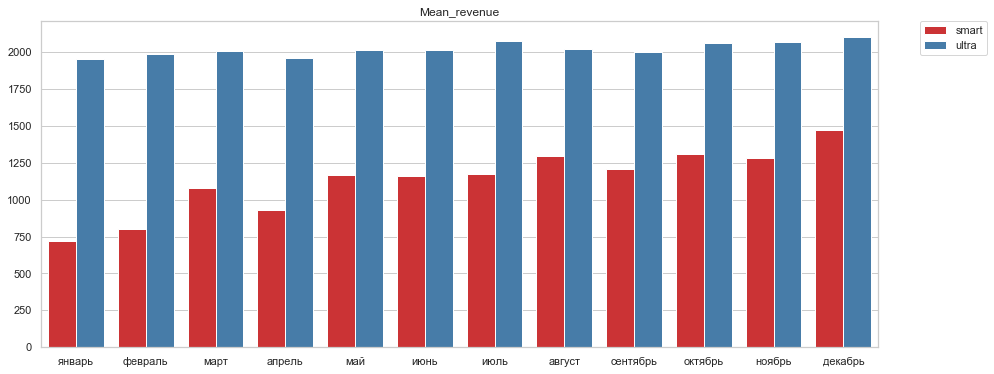

In [69]:
make_a_plot(data_pivot, 'mean_revenue')

#### Выводы:

- По графику средней прибыли очевидно что тариф Ultra приносит компании больше прибыли, однако существование тариф Smart объяснимо тем, что компании необходимо держать разные ниши клиентов. Можно сказать что тариф Smart разработан специально для менее обеспеченных групп клиентов.
- Так же на данном этапе интересно отметить что тариф Ultra от месяца к месяцу не изменяет сильно свои потребности, то есть клиенты тратят в среднем одинаковые суммы каждый месяц и более того чаще всего умещаются в нетарифицируемый порог в 1950 рублей.
- Тариф Smart более чувствителен к сезону и видна такая тенденция, что в начале года траты меньше чем к концу года. При этом нетарифицируемый порог в 500 рублей в среднем превышается каждый месяц.

##### 2. Сравним среднее количество затрачиваемых минут:

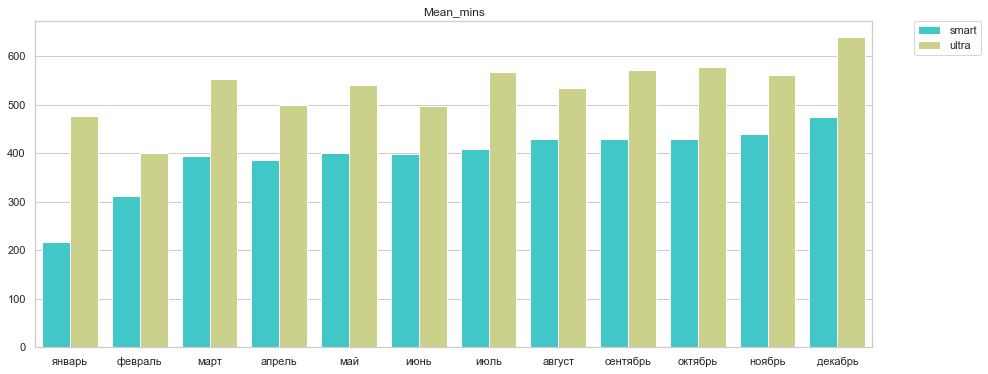

In [70]:
make_a_plot(data_pivot, 'mean_mins', palette='rainbow')

#### Выводы:

- Данный график показывает что пользователи тарифа Ultra в целом активнее пользуются связью чем пользователи тарифа Smart.
- Пользователи Ultra в среднем не выговаривают и половины предложенного нетарифицируемого порога в 3000 минут.
- Пользователи Smart ближе к цели и особенно к концу года в среднем тяготеют к нетарифицируемому порогу в 500 минут, согласно тарифу.

##### 3. Сравним среднее количество отправленных СМС сообщений:

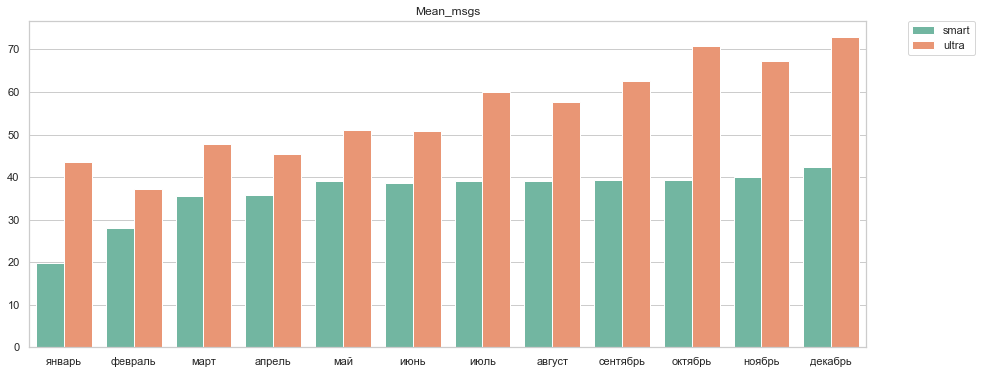

In [71]:
make_a_plot(data_pivot, 'mean_msgs', palette='Set2')

#### Выводы:

- Примечательно что оба тарифа в течение года отправляют все больше смс-сообщений.
- Пользователи тарифа Smart отправляют в среднем одинаковое количество смс в месяц (на 10-15 сообщений меньше, чем в установленном пороге в 50 смс).
- Пользователи тарифа Ultra варьируются по средним показателям и отправляют в 10-12 раз меньше нетарифицируемого порога в 1000 смс.

##### 4. Сравним среднее количество интернет-трафика:

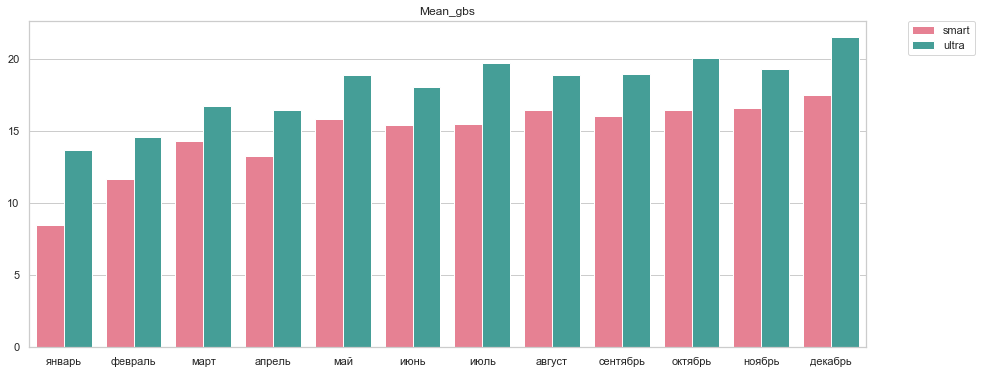

In [72]:
make_a_plot(data_pivot, 'mean_gbs', palette='husl') 

#### Выводы:

- Пользователи тарифа Smart в среднем тратят весь нетарифицируемый трафик в 15 Гб, и даже часто превышают его.
- Пользователи тарифа Ultra затрачивают примерно на 10 Гб меньше чем тарифицируемый порог в 30 Гб.
- Сравнивая тарифы между собой можно сказать, что потребности в интернете похожи у пользователей обоих тарифов. Однако основываясь на предположении, что Smart тариф разработан для группы эконом класса и благодаря низким нетарифицируемым порогам обладает большей гибкостью, пользователи этого тарифа заведомо экономят на трафике.

### Проверим гипотезы

- ***средняя выручка пользователей тарифов «Ультра» и «Смарт» различается:***

Нулевая гипотеза - "средняя выручка от пользователей тарифов не различается"

Альтернативная гипотеза - "средняя выручка от пользователей различается"

In [73]:
ultra_total_rev = total_data[total_data['tariff_name'] == 'ultra']['revenue'].array
smart_total_rev = total_data[total_data['tariff_name'] == 'smart']['revenue'].array

Применим метод гипотезы о равенстве средних двух генеральных совокупностей:

In [74]:
alpha = .05
result = st.ttest_ind(ultra_total_rev, smart_total_rev)

print('p-значение:\t', result.pvalue)

if (result.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Нулевую гипотезу отвергнуть не получилось')

p-значение:	 4.397294342687966e-142
Отвергаем нулевую гипотезу


#### Вывод:

Результаты говорят о том, что нулевая гипотеза не состоятельна. То что тарифы Smart и Ultra идентичны не доказано.

- ***средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов:***

Нулевая гипотеза - "средняя выручка по Москве равна выручке от пользователей из других регионов"

Альтернативная гипотеза - "средняя выручка по Москве отлична от выручки из других регионов"

In [75]:
moscow_rev = total_data[total_data['city'] == 'Москва']['revenue'].array
other_rev = total_data[total_data['city'] != 'Москва']['revenue'].array

Применим метод гипотезы о равенстве средних двух генеральных совокупностей:

In [76]:
alpha = .05
result = st.ttest_ind(moscow_rev, other_rev)

print('p-значение:\t', result.pvalue)

if (result.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Нулевую гипотезу отвергнуть не получилось')

p-значение:	 0.07890674212588042
Нулевую гипотезу отвергнуть не получилось


#### Вывод:

На уровне значимости 0.05 данные не свидетельствуют против гипотезы "средняя выручка по Москве равна выручке от пользователей из других регионов". Нулевую гипотезу отвергнуть не удалось.

In [77]:
total_mean = data_pivot['mean_revenue'].mean()

Вероятность попасть средним в доверительный интервал по Москве:

In [78]:
mos_mu = moscow_rev.mean()
mos_sigma = moscow_rev.std()
m_distr = st.norm(mos_mu, mos_sigma)

m_distr.cdf(total_mean)

0.531598925680403

Вероятность попасть средним в доверительный интервал по другим регионам:

In [79]:
oth_mu = other_rev.mean()
oth_sigma = other_rev.std()
oth_distr = st.norm(oth_mu, oth_sigma)

oth_distr.cdf(total_mean)

0.5648845645145445

Для уточнения изучим график распределения средней выручки по городам:

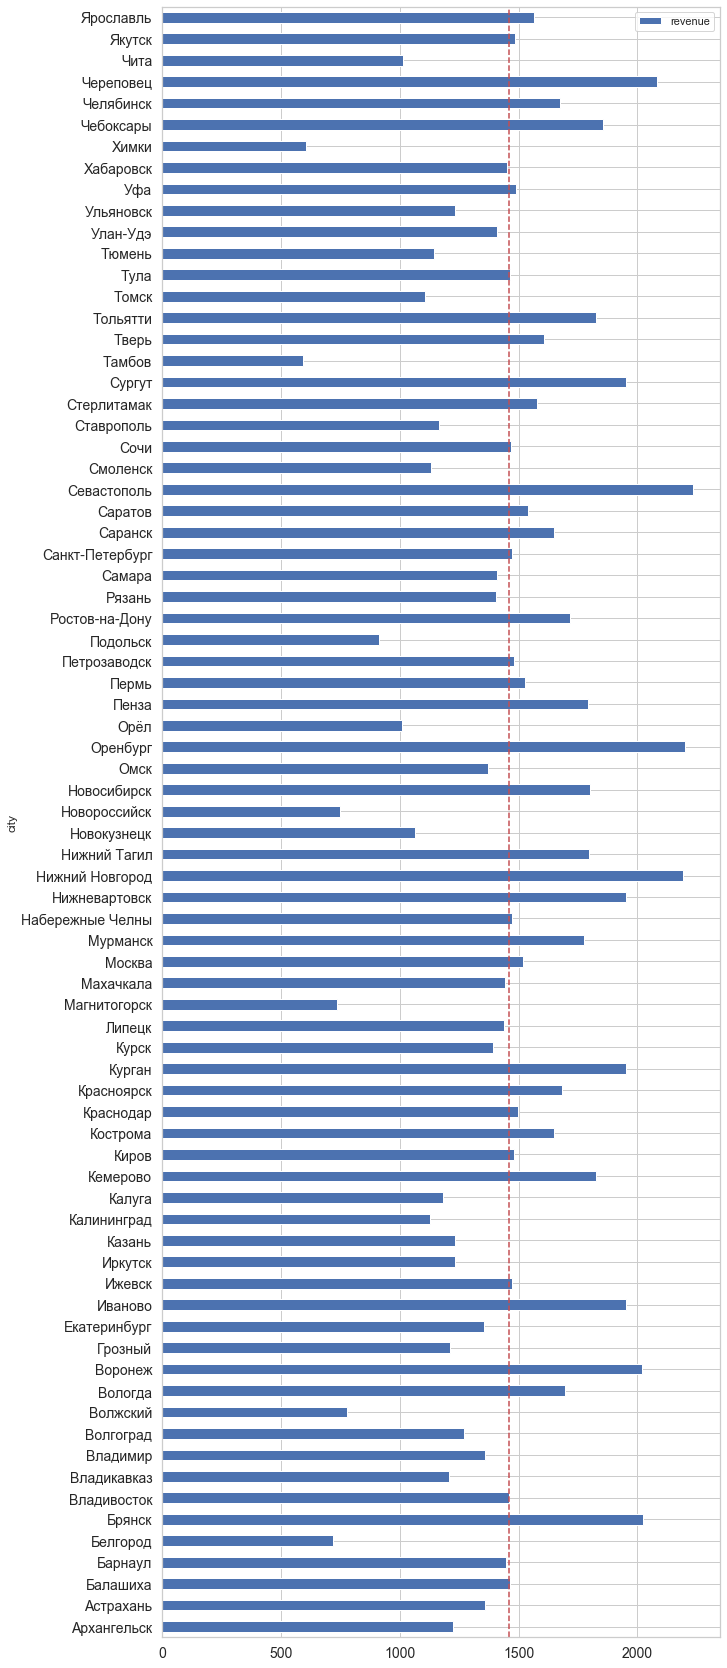

In [80]:
cities = total_data.pivot_table(index='city', values='revenue')
cities_mean = cities['revenue'].mean()
cities.plot(y='revenue', figsize=(10,30), kind='barh', grid=True, fontsize=14).axvline(cities_mean, color='r', linestyle='--')

Согласно графику Москва показывает средние показатели (среднее указано красным пунктиром). Однако есть отдельные города, которые согласно заданной генеральной совокупности приносят больше прибыли компании.

## Общий вывод

**Тариф "Ultra":**

- Тариф приносит компании больше прибыли (из-за более высоких порогов оплаты и стоимости абонентской платы);
- Интересно отметить что пользователи тарифа от месяца к месяцу приносят примерно одинаковую прибыль, чаще всего умещаясь в нетарифицируемый порог(1950 рублей);
- Заметно что пользователи данного тарифа в целом активнее пользуются связью чем пользователи тарифа Smart. Предположительно, что высокий порог абонентсткой платы по сути делает из тарифа практических безлимитный.
- Пользователи тарифа в среднем не выговаривают и половины предложенного нетарифицируемого порога(в 3000 минут). Предлагается разработать дополнительные промежуточные тарифы или опять же подумать над гибкой тарификацией. Например, самообущающейся системой, которая самостоятельно предлагала бы параметры тарификации в зависимости от нужд клиента.
- Отправка смс-сообщений пользователями данного тарифа варьируются по средним показателям. Абоненты отправляют в 10-12 раз меньше сообщений чем нетарифицируемый порог(1000 смс).
- Пользователи тарифа затрачивают примерно на 10 Гб меньше чем тарифицируемый порог в 30 Гб. Но похоже, что как и в случае с тарифом в целом, этих пользователей это не сильно заботит. Вероятно тариф рассматривают как некий аналог тарифа с безлимитным интернетом.

**Тариф "Smart":**

- Сам факт существования тарифа Smart объясним тем, что компании необходимо держать разные ниши клиентов. Можно сказать что тариф Smart разработан специально для менее обеспеченных групп клиентов (предположительно именно так и видела свою стратегию компания);
- Тариф более чувствителен к сезону и видна такая тенденция, что в начале года траты меньше чем к концу года. При этом нетарифицируемый порог в 500 рублей в среднем превышается каждый месяц. Возможно стоит задуматься о гибких инструментах изменения порога, по желанию клиента или других бонусах.
- Пользователи этого тарифа особенно к концу года в среднем тяготеют к нетарифицируемому порогу в 500 минут, согласно тарифу. То есть по сути постоянно исчерпывают полностью весь лимит. Предположительно, это более экономные люди, которые предпочитают выговаривать все вложенные средства ("получу всё, за что я заплатил").
- Пользователи тарифа отправляют в среднем одинаковое количество смс от месяца к месяцу (на 10-15 сообщений меньше, чем в установленном пороге в 50 смс).
- Пользователи тарифа в среднем тратят весь нетарифицируемый трафик в 15 Гб, и даже часто превышают его. Опять же очевидно, что требуются более гибкие предложения по тарификации, которе позволят увеличивать потребление трафика.

**Общие выводы:**

- Примечательно что оба тарифа в течение года отправляют все больше смс-сообщений.
- Сравнивая тарифы между собой можно сказать, что потребности в интернете похожи у обеих групп. Однако основываясь на предположении, что Smart тариф разработан для группы эконом класса и благодаря низким нетарифицируемым порогам обладает большей гибкостью. В результате пользователи последнего тарифа заведомо экономят на трафике.
- Результаты говорят о том, что нулевая гипотеза не состоятельна. То что тарифы Smart и Ultra идентичны не доказано.
- На уровне значимости 0.05 данные не свидетельствуют против гипотезы "средняя выручка по Москве равна выручке от пользователей из других регионов". Нулевую гипотезу отвергнуть не удалось.
- Согласно графику Москва показывает средние показатели (среднее указано красным пунктиром). Однако есть отдельные города, которые согласно заданной генеральной совокупности приносят больше прибыли компании.